### EEC227C HW2 Q1, Yigit Efe Erginbas

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

In [3]:
A = np.zeros((5,10,10))
b = np.zeros((5,10))

In [4]:
for k in range(5):
    for i in range(10):
        for j in range(10):
            if i < j:
                A[k,i,j] = np.exp((i+1) / (j+1)) * np.cos((i+1) * (j+1)) * np.sin(k+1)
            if i > j:
                A[k,i,j] = np.exp((j+1) / (i+1)) * np.cos((j+1) * (i+1)) * np.sin(k+1)

for k in range(5):
    for i in range(10):
        A[k,i,i] = (i+1)/10 * np.abs(np.sin(k+1)) + np.sum(np.abs(A[k, i, :]))
        
for k in range(5):
    for i in range(10):        
        b[k, i] = np.exp((i+1) / (k+1)) * np.sin((i+1) * (k+1))

In [5]:
def f_eval(x):
    
    f_k = np.zeros(5)
    
    for k in range(5):
        f_k[k] = x.T @ A[k] @ x - x.T @ b[k]
    
    return np.max(f_k), np.argmax(f_k)

def f_grad(x):
    _, k_star = f_eval(x)
    return 2 * A[k_star] @ x - b[k_star]

Evaluate $f(x^{1})$:

In [6]:
f_eval(np.ones(10))

(5337.066429311364, 0)

Check if all $A_k$ are PSD:

In [7]:
for k in range(5):
    print(np.min(np.linalg.eig(A[k])[0]) > 0)

True
True
True
True
True


## Solve with CVXOPT to obtain the optimal point & value

In [82]:
import cvxpy as cp

x = cp.Variable(10)

Fi = []
for k in range(5):
    Fi.append(cp.quad_form(x, A[k]) - x.T @ b[k])

objective = cp.Minimize(cp.maximum(*Fi))
prob = cp.Problem(objective)
optimal_value = prob.solve()

x_opt = np.array(x.value)

print('Optimal Value = ', optimal_value)
print(x_opt)

Optimal Value =  -0.8414083342169737
[-0.12625655 -0.03437833 -0.00685703  0.02636084  0.06729451 -0.27839957
  0.07421914  0.13852438  0.08403105  0.03858013]


## Level Method

In [55]:
def minimize_bundle(bundle):
    x_values, f_values, grads = bundle
    x = cp.Variable(10)
    obj_val = cp.max(f_values + cp.sum(cp.multiply(grads, (cp.reshape(x, (10, 1)) - x_values)), axis=0))
    objective = cp.Minimize(obj_val)
    # include the following constraint in order to avoid unbounded objective values
    constraints = [cp.norm2(x) <= 100]
    prob = cp.Problem(objective, constraints)
    result = prob.solve()
    return x.value, result

In [56]:
def projection(x_prev, level, bundle):
    x_values, f_values, grads = bundle
    x = cp.Variable(10)
    constraints = [f_values + cp.sum(cp.multiply(grads, (cp.reshape(x, (10, 1)) - x_values)), axis=0) <= level]
    objective = cp.Minimize(cp.norm2(x - x_prev))
    prob = cp.Problem(objective, constraints)
    result = prob.solve()
    return x.value

In [96]:
lmbd = 0.5
x = np.ones(10)
T = 500
C = 1e-3
hist = np.zeros(T)
best_value = np.inf

grads = []
f_values = []
x_values = []

for t in range(T):
        
    current_value, _ = f_eval(x)
    
    if current_value < best_value:
        best_value = current_value
    hist[t] = best_value
    
    x_values.append(x)
    f_values.append(current_value)
    grads.append(f_grad(x))
    
    bundle = x_values, f_values, grads 

    _, f_minus = minimize_bundle(bundle)
    f_plus = np.min(f_values)

    level = (1 - lmbd) * f_minus + lmbd * f_plus

    x = projection(x, level, bundle)

In [97]:
print('Best Value = ', best_value)

Best Value =  -0.8414083344552934


## Results

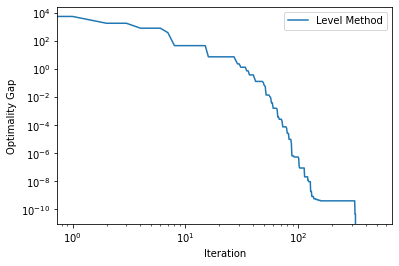

In [98]:
plt.plot(hist - optimal_value, label="Level Method")
plt.xscale('log')
plt.yscale('log')

plt.ylabel('Optimality Gap')
plt.xlabel('Iteration')
plt.legend()
plt.show()